In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()


'/device:GPU:0'

In [ ]:
!pip install catboost==0.26


     |████████████████████████████████| 69.2 MB 16 kB/s 


In [ ]:
!pip install transformers


     |████████████████████████████████| 3.4 MB 5.2 MB/s 
     |████████████████████████████████| 895 kB 47.3 MB/s 
     |████████████████████████████████| 67 kB 5.1 MB/s 
     |████████████████████████████████| 3.3 MB 38.7 MB/s 
     |████████████████████████████████| 596 kB 46.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import os
import inflect
import nltk
import pickle
import re, string, unicodedata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns




In [ ]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import classification_report, confusion_matrix
from nltk.corpus import stopwords
from catboost.utils import get_confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score


import warnings
warnings.filterwarnings('ignore')


In [ ]:
industry_type_df = pd.read_excel("/content/Book2.xlsx", sheet_name = "Sheet3")

print(industry_type_df.head())


                                            Sentence               Class
0  Manufacturer and provider of automotive parts....  Technology driven 
1  Provider of financing services based in Mexico...  Technology driven 
2  Jaze is a bluetooth-enabled mobile app that tu...  Technology driven 
3  Provider of metal and plastic plating services...  Technology driven 
4  G&amp;A Marketing is an automotive company spe...  Technology driven 


In [ ]:
industry_type_df = industry_type_df.rename(columns={"Sentence": "description", "Class": "data_type"})
# print(industry_type_df.columns)
industry_type_df.head(10)

,description,data_type
0,Manufacturer and provider of automotive parts....,Technology driven
1,Provider of financing services based in Mexico...,Technology driven
2,Jaze is a bluetooth-enabled mobile app that tu...,Technology driven
3,Provider of metal and plastic plating services...,Technology driven
4,G&amp;A Marketing is an automotive company spe...,Technology driven
5,Vamshi Rubber Ltd is engaged in the business o...,Technology driven
6,Provider of automotive auctions services. The ...,Technology driven
7,Hiway Fuel Services is a risk management compa...,Technology driven
8,"APTA, Special Employment Center is an Asturian...",Technology driven
9,Manufacturer of battery operated electric vehi...,Technology driven


In [ ]:
industry_type_df.isna().sum()

description    0
data_type      0
tag_1          0
dtype: int64

In [ ]:
ind_dict = dict()
count = 1
for i in sorted(set(industry_type_df['data_type'])):
    ind_dict[i] = count
    count = count + 1

In [ ]:
ind_dict

{'Non-Technology driven ': 1, 'Technology driven ': 2}

In [ ]:
industry_type_df = industry_type_df[['description','data_type']]

In [ ]:
industry_type_df = industry_type_df.sample(frac = 1)
industry_type_df.head(5)

,description,data_type
493,Dartington Crystal was founded in 1967. Dartin...,Non-Technology driven
536,Dixon motors is a used car dealer and finance ...,Non-Technology driven
131,Developer of an investment-type crowdfunding m...,Technology driven
463,Modimize is a social fashion network that allo...,Non-Technology driven
606,Longo Lexus is a car dealership located in El ...,Non-Technology driven


In [ ]:
industry_type_df = industry_type_df.assign(data_type_labels = industry_type_df['data_type'].apply(lambda x:ind_dict[x]))
industry_type_df.head(5)

,description,data_type,data_type_labels
493,Dartington Crystal was founded in 1967. Dartin...,Non-Technology driven,1
536,Dixon motors is a used car dealer and finance ...,Non-Technology driven,1
131,Developer of an investment-type crowdfunding m...,Technology driven,2
463,Modimize is a social fashion network that allo...,Non-Technology driven,1
606,Longo Lexus is a car dealership located in El ...,Non-Technology driven,1


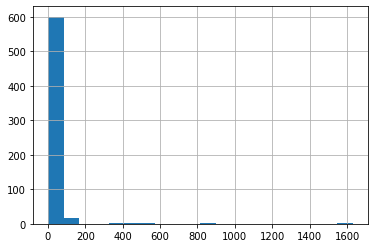

In [ ]:
# get length of all the messages in the train set
seq_len = [len(str(i).split()) for i in industry_type_df['description'].tolist()]

pd.Series(seq_len).hist(bins = 20)

In [ ]:
max(seq_len), min(seq_len)

(1630, 2)

In [ ]:
len(seq_len)

626

In [ ]:
industry_type_df = industry_type_df.assign(seq_len = seq_len)
industry_type_df.head(2)

,description,data_type,data_type_labels,seq_len
493,Dartington Crystal was founded in 1967. Dartin...,Non-Technology driven,1,55
536,Dixon motors is a used car dealer and finance ...,Non-Technology driven,1,13


In [ ]:
industry_type_df = industry_type_df[['description', 'data_type_labels']]

In [ ]:
df_train = industry_type_df[0:int(industry_type_df.shape[0]*0.90)]
df_test = industry_type_df[0:int(industry_type_df.shape[0]*0.10)]

In [ ]:
train, valid = train_test_split(
    df_train,
    train_size=0.80,
    random_state=0,
    stratify=df_train['data_type_labels'])

y_train, X_train = train['data_type_labels'], train.drop(['data_type_labels'], axis=1)
y_valid, X_valid = valid['data_type_labels'], valid.drop(['data_type_labels'], axis=1)

In [ ]:
X_train.shape, X_valid.shape

((306, 1), (77, 1))

In [ ]:
y_train

2377    15
362      9
1972     3
4183    14
12       3
        ..
841      9
22       3
583      5
3648    10
4139    14
Name: data_type_labels, Length: 3032, dtype: int64

In [ ]:
train_pool = Pool(
    data=X_train,
    label=y_train,
    text_features=['description']
)

valid_pool = Pool(
    data=X_valid, 
    label=y_valid,
    text_features=['description']
)

test_pool = Pool(
    data=df_test[[c for c in df_test.columns if c!='data_type_labels']][['description']], 
    label=df_test['data_type_labels'],
    text_features=['description']
)

In [ ]:
def fit_model(train_pool, test_pool, **kwargs):
    model = CatBoostClassifier(
        task_type='GPU',
        iterations=5000,
        eval_metric='Accuracy',
        od_type='Iter',
        od_wait=500,
        **kwargs
    )

    return model.fit(
        train_pool,
        eval_set=test_pool,
        verbose=100,
        plot=True,
        use_best_model=True)

In [ ]:
model = fit_model(
    train_pool, valid_pool,
    learning_rate=0.35,
    tokenizers=[
        {
            'tokenizer_id': 'Sense',
            'separator_type': 'BySense',
            'lowercasing': 'True',
            'token_types':['Word', 'Number', 'SentenceBreak'],
            'sub_tokens_policy':'SeveralTokens'
        }      
    ],
    dictionaries = [
        {
            'dictionary_id': 'Word',
            'max_dictionary_size': '50000'
        }
    ],
    feature_calcers = [
        'BoW:top_tokens_count=10000'
    ]
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.7908497	test: 0.7792208	best: 0.7792208 (0)	total: 53.2ms	remaining: 4m 25s
100:	learn: 1.0000000	test: 0.8961039	best: 0.9350649 (12)	total: 4.39s	remaining: 3m 33s
200:	learn: 1.0000000	test: 0.8831169	best: 0.9350649 (12)	total: 8.47s	remaining: 3m 22s
300:	learn: 1.0000000	test: 0.8831169	best: 0.9350649 (12)	total: 12.5s	remaining: 3m 15s
400:	learn: 1.0000000	test: 0.8961039	best: 0.9350649 (12)	total: 16.7s	remaining: 3m 11s
500:	learn: 1.0000000	test: 0.8961039	best: 0.9350649 (12)	total: 20.8s	remaining: 3m 6s
bestTest = 0.9350649351
bestIteration = 12
Shrink model to first 13 iterations.


In [ ]:
y_proba_cb = model.predict_proba(test_pool)
y_pred = np.argmax(y_proba_cb, axis=1)
df_test.assign(predict = model.predict(test_pool))
# df_test['predict'] = model.predict(test_pool)

,description,data_type_labels,predict
216,"Autoropa is a car dealer of Ferrari, Maserati ...",1,1
176,Sundaram Fasteners Ltd is an Indian producer o...,1,1
161,Baxter Auto Group is a family-owned and locall...,1,1
131,Supplier of tier 1 brakes and suspension parts...,1,1
2,Jaze is a bluetooth-enabled mobile app that tu...,2,1
195,"Operator of car wash stores based in Bay City,...",1,1
9,Manufacturer of battery operated electric vehi...,2,2
206,Operator of a platform intended to offer vehic...,1,1
175,Lochmandy Auto Group engages in the sales and ...,1,1
204,We continue to be your prime location for Sell...,1,1


In [ ]:
acc = model.score(test_pool)
print(f"CatBoost model accuracy: {acc}")

CatBoost model accuracy: 0.9285714285714286


In [ ]:
model.save_model('company_classification_model_new') 

In [ ]:
def question_type_prediction(sentence):
    model = CatBoostClassifier()
    model.load_model('./company_classification_model_new')
    model_prediction = model.predict([sentence])
    # prediction = [('additional information' if i == 1 else ('clarification' if i == 2 else 'findability')) for i in
    #               model_prediction]
    # print("model_prediction:", model_prediction)
    if model_prediction == 1:
      prediction = 'Non-Technology driven(Supplier)'
    else:
      prediction = 'Technology driven(Manufacturer)'  
    # prediction = [('Non-Technology driven(Supplier)' if i == 1 else ('Technology driven(Manufacturer))') for i in model_prediction]
    # string_output=' '.join(map(str,prediction))
    return prediction


In [ ]:
question_type_prediction('Provider of online driver defensive training courses. The company provides traffic instruction and improvement courses for its customers who have received a traffic ticket or want to reduce their auto insurance premiums.')

'Technology driven(Manufacturer)'

In [ ]:
test_data = pd.read_excel("/content/company_classification_phrases.xlsx", sheet_name = "Test")
test_data.head()

,Sentence,Type
0,GreenByte Technologies is an IT company that p...,Technology
1,VLDB Solutions are an independent data consult...,Technology
2,Provider of software solutions based in Ingols...,Technology
3,Provider of a phone-to-television videosharing...,Technology
4,Developer of a medical healthcare software int...,Technology


In [ ]:
preds = []
for idx in range(len(test_data)):
  Sentence = test_data.loc[idx]['Sentence']
  prediction = question_type_prediction(Sentence)
  preds.append(prediction)
test_data['prediction'] = preds  




model_prediction: 1
model_prediction: 2
model_prediction: 2
model_prediction: 2
model_prediction: 2
model_prediction: 1
model_prediction: 2
model_prediction: 1
model_prediction: 2
model_prediction: 2
model_prediction: 1
model_prediction: 1
model_prediction: 2
model_prediction: 2
model_prediction: 1
model_prediction: 2
model_prediction: 2
model_prediction: 2
model_prediction: 1
model_prediction: 1
model_prediction: 2
model_prediction: 2
model_prediction: 2
model_prediction: 2
model_prediction: 2
model_prediction: 2
model_prediction: 1
model_prediction: 1
model_prediction: 2
model_prediction: 2
model_prediction: 2
model_prediction: 2
model_prediction: 2
model_prediction: 2
model_prediction: 2
model_prediction: 1
model_prediction: 1
model_prediction: 2
model_prediction: 2
model_prediction: 2
model_prediction: 2
model_prediction: 2
model_prediction: 1
model_prediction: 1
model_prediction: 1
model_prediction: 2
model_prediction: 1
model_prediction: 2
model_prediction: 1
model_prediction: 2


In [ ]:
test_data.head()

,Sentence,Type,prediction
0,GreenByte Technologies is an IT company that p...,Technology,Non-Technology driven(Supplier)
1,VLDB Solutions are an independent data consult...,Technology,Technology driven(Manufacturer)
2,Provider of software solutions based in Ingols...,Technology,Technology driven(Manufacturer)
3,Provider of a phone-to-television videosharing...,Technology,Technology driven(Manufacturer)
4,Developer of a medical healthcare software int...,Technology,Technology driven(Manufacturer)


In [ ]:
test_data.to_excel("company_classofocation.xlsx")